In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.utils import plot_model

import os
print(os.listdir("../input"))

Using TensorFlow backend.


['avhikeathonfeatparquet', 'avhikeathon', 'avhikeathonfeatparquettest']


In [2]:
train = pd.read_parquet('../input/avhikeathonfeatparquet/av-hikeathon-feat.parquet')
test = pd.read_parquet('../input/avhikeathonfeatparquettest/av-hikeathon-feat-test.parquet')

In [3]:
train_sample = pd.concat([train[train.is_chat==1],
                          train[train.is_chat==0].sample(train.is_chat.sum() * 2)])
del train
gc.collect()

21

In [4]:
train_sample.head(2)

,node1_id,node2_id,prev_is_chat,is_chat,f1_n1,f2_n1,f3_n1,f4_n1,f5_n1,f6_n1,f7_n1,f8_n1,f9_n1,f10_n1,f12_n1,f13_n1,f1_n2,f2_n2,f3_n2,f4_n2,f5_n2,f6_n2,f7_n2,f8_n2,f9_n2,f10_n2,f12_n2,f13_n2
108,6708917,1580,1,1,31,28,1,31,28,1,31,29,1,31,1,7,23,3,0,29,6,0,31,6,0,31,1,8
139,2709023,1645,1,1,31,16,1,31,17,4,31,18,5,31,11,10,0,0,0,0,0,0,0,0,0,0,0,15


In [5]:
test.head(2)

,id,node1_id,node2_id,prev_is_chat,f1_n1,f2_n1,f3_n1,f4_n1,f5_n1,f6_n1,f7_n1,f8_n1,f9_n1,f10_n1,f12_n1,f13_n1,f1_n2,f2_n2,f3_n2,f4_n2,f5_n2,f6_n2,f7_n2,f8_n2,f9_n2,f10_n2,f12_n2,f13_n2
0,7727769,6877352,148,0,31,12,5,31,11,6,31,10,8,31,9,8,31,30,0,31,30,0,31,30,0,31,0,15
1,6000097,7312923,148,0,19,13,1,26,17,1,31,22,1,31,1,15,31,30,0,31,30,0,31,30,0,31,0,15


In [6]:
feature = ['prev_is_chat', 'f1_n1', 'f2_n1', 'f3_n1', 'f4_n1', 'f5_n1', 'f6_n1', 'f7_n1', 'f8_n1',
           'f9_n1', 'f10_n1', 'f12_n1', 'f13_n1', 'f1_n2', 'f2_n2', 'f3_n2', 'f4_n2', 'f5_n2',
           'f6_n2', 'f7_n2', 'f8_n2', 'f9_n2', 'f10_n2', 'f12_n2', 'f13_n2']
label = 'is_chat'

In [7]:
X_train = train_sample[feature]
y = train_sample[label]

X_test = test[feature]
submission = test.loc[:,['id']]

In [8]:
model = Sequential()
model.add(Dense(64, input_dim=len(feature), activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']);

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
history = model.fit(X_train, y,
                    validation_split=0.20,
                    epochs=50,
                    batch_size=2048)

Instructions for updating:
Use tf.cast instead.
Train on 5404281 samples, validate on 1351071 samples
Epoch 1/50
5404281/5404281 [==============================] - 17s 3us/step - loss: 0.5991 - acc: 0.7414 - val_loss: 0.5096 - val_acc: 0.8341
Epoch 2/50
5404281/5404281 [==============================] - 15s 3us/step - loss: 0.4841 - acc: 0.7924 - val_loss: 0.4241 - val_acc: 0.9079
Epoch 3/50
5404281/5404281 [==============================] - 15s 3us/step - loss: 0.4744 - acc: 0.7936 - val_loss: 0.4044 - val_acc: 0.9127
Epoch 4/50
5404281/5404281 [==============================] - 15s 3us/step - loss: 0.4703 - acc: 0.7937 - val_loss: 0.3738 - val_acc: 0.9155
Epoch 5/50
5404281/5404281 [==============================] - 16s 3us/step - loss: 0.4679 - acc: 0.7947 - val_loss: 0.3880 - val_acc: 0.9163
Epoch 6/50
5404281/5404281 [==============================] - 16s 3us/step - loss: 0.4664 - acc: 0.7950 - val_loss: 0.4082 - val_acc: 0.9108
Epoch 7/50
5404281/5404281 [========================

In [10]:
scores = model.evaluate(X_train, y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 82.18%


In [11]:
plot_model(model, to_file='model.png')

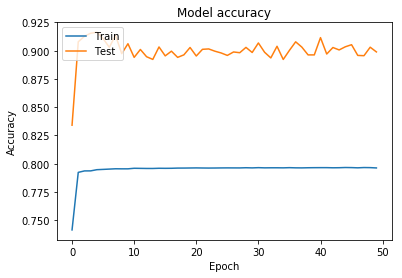

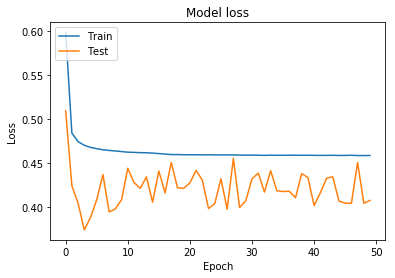

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [13]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [14]:
submission[label] = model.predict(X_test)

In [15]:
submission.to_csv('submission.csv', compression='zip', index=False)